In [0]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import numpy as np
import json
import warnings
warnings.filterwarnings('ignore')
import base64
import io
from matplotlib.pyplot import imread
import codecs
from IPython.display import HTML

In [0]:
import psycopg2

# PostgreSQL database connection parameters
db_params = {
    'host': '',
    'dbname': 'movie',
    'user': 
    'password': '
'    'sslmode': 'require'
}

try:
    connection = psycopg2.connect(**db_params)
    cursor = connection.cursor()

    query = ["SELECT * FROM title_basics WHERE titleType='movie' LIMIT 20  " , "SELECT * FROM title_ratings LIMIT 20"] # Corrected query
    cursor.execute(query[0])
    rows1 = cursor.fetchall()  # Fetch the results
    columns1 = [desc[0] for desc in cursor.description]
    df1 = pd.DataFrame(rows1, columns=columns1)

    cursor.execute(query[1])
    rows2 = cursor.fetchall()  # Fetch the results
    columns2 = [desc[0] for desc in cursor.description]
    df2 = pd.DataFrame(rows2, columns=columns2)

    connection.commit()

except (Exception, psycopg2.Error) as error:
    print("Error:", error)

finally:
    if connection:
        cursor.close()
        connection.close()
        print("Database connection closed.")

Database connection closed.


In [0]:
df1.head()

,tconst,titletype,primarytitle,originaltitle,isadult,startyear,endyear,runtimeminutes,genres
0,tt13710866,movie,Unnecessary Roughness,Unnecessary Roughness,0,2021,None,None,Drama
1,tt1371087,movie,Bagnaia,Bagnaia,0,1915,None,None,None
2,tt13710918,movie,Ameera,Ameera,0,2021,None,91,Drama
3,tt1371100,movie,Bugergiaria,Bugergiaria,0,1921,None,None,None
4,tt1371104,movie,Candy Land,Candy Land,0,None,None,None,Adventure


In [0]:
df2.head()

,tconst,averagerating,numvotes
0,tt0000001,5.7,1990
1,tt0000002,5.8,265
2,tt0000003,6.5,1857
3,tt0000004,5.5,178
4,tt0000005,6.2,2643


In [0]:
movies = df1.merge(df2,left_on='tconst',right_on='tconst',how='left')
# movies = movies[['id','original_title','genres','cast','vote_average','director','keywords']]
movies = movies[['tconst','originaltitle','genres','isadult','startyear','runtimeminutes','averagerating','numvotes']]

In [0]:
movies['genres'] = movies['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['genres'] = movies['genres'].str.split(',')

In [0]:
movies['genres'].head(10)

0    [Documentary, Short]
1                 [Short]
2                [Sci-Fi]
3                 [Drama]
4                 [Adult]
5                 [Drama]
6          [Drama, Short]
7                 [Drama]
8                 [Drama]
9                 [Drama]
Name: genres, dtype: object

In [0]:
movies = movies[movies['genres'].notna()]
# movies = movies[movies['averagerating'].notna()]
# movies = movies[movies['numvotes'].notna()]



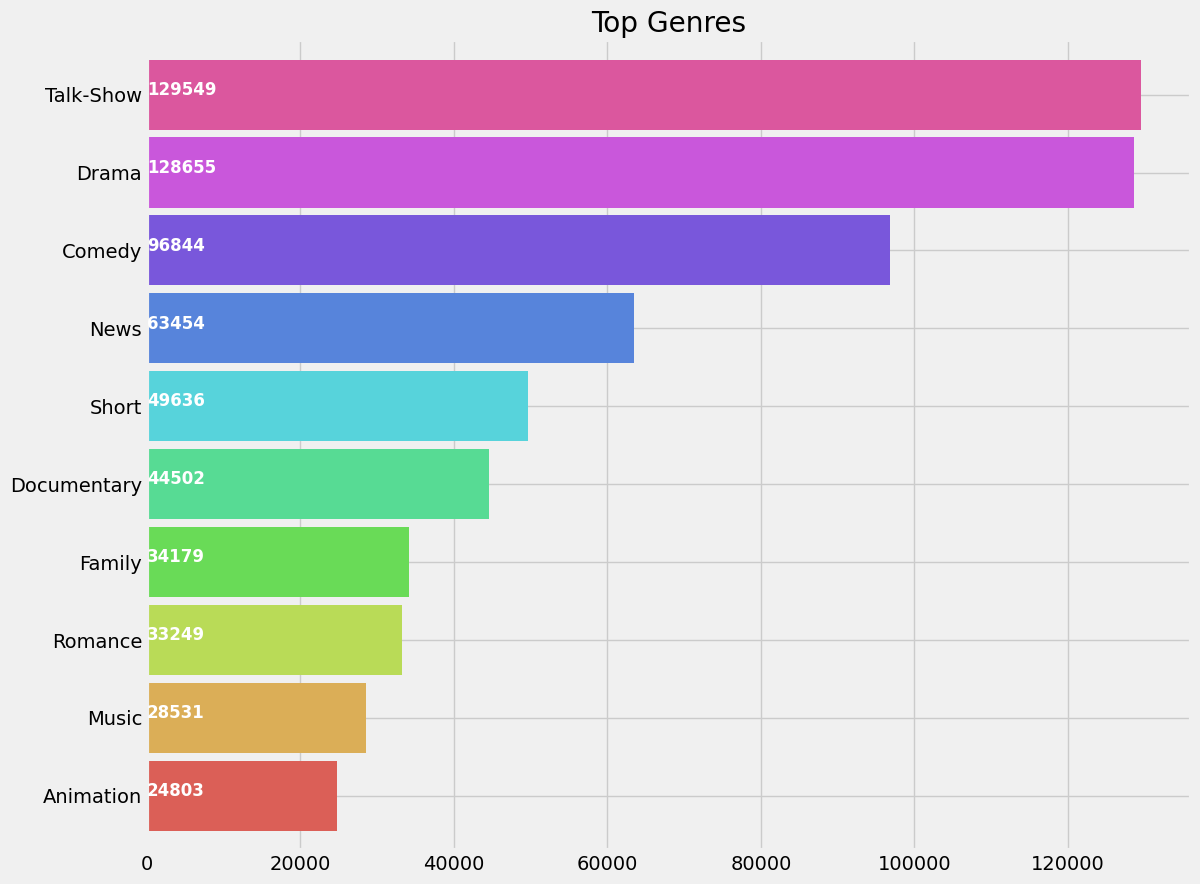

In [0]:
plt.subplots(figsize=(12,10))
list1 = []
genereList = set()
for i in movies['genres']:
    list1.extend(i)
ax = pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('hls',10))
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values):
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top Genres')
plt.show()

In [0]:
genreList = []
for index, row in movies.iterrows():
    genres = row["genres"]
    
    for genre in genres:
        if genre not in genreList:
            genreList.append(genre)


In [0]:
def binary(genre_list):
    binaryList = []
    
    for genre in genreList:
        if genre in genre_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

In [0]:
movies['genres_bin'] = movies['genres'].apply(lambda x: binary(x))
movies['genres_bin'].head()

0    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
4    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
5    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
6    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
Name: genres_bin, dtype: object

In [0]:
from scipy import spatial
def Similarity(movieId1, movieId2):
    a = movies.iloc[movieId1]
    b = movies.iloc[movieId2]
    
    genresA = a['genres_bin']
    genresB = b['genres_bin']
    
    genreDistance = spatial.distance.cosine(genresA, genresB)
    return genreDistance

In [0]:
new_id = list(range(0,movies.shape[0]))
movies['new_id']=new_id
# movies=movies[['original_title','genres','vote_average','genres_bin','cast_bin','new_id','director','director_bin','words_bin']]
movies = movies[['new_id','tconst','originaltitle','genres','genres_bin','isadult','startyear','runtimeminutes','averagerating','numvotes']]


In [0]:

import operator

def predict_score(name):
    matching_movies = movies[movies['originaltitle'].str.contains(name)]

    if matching_movies.empty:
        print(f"No movies found with a title containing '{name}'.")
        return

    new_movie = matching_movies.iloc[0].to_frame().T
    print('Selected Movie:', new_movie.originaltitle.values[0])

    def getNeighbors(baseMovie, K):
        distances = []

        for index, movie in movies.iterrows():
            if movie['new_id'] != baseMovie['new_id'].values[0]:
                dist = Similarity(baseMovie['new_id'].values[0], movie['new_id'])
                distances.append((movie['new_id'], dist))

        distances.sort(key=operator.itemgetter(1))
        neighbors = []

        for x in range(min(K, len(distances))): 
            neighbors.append(distances[x])

        return neighbors

    K = 10
    avgRating = 0.0
    neighbors = getNeighbors(new_movie, K)

    print('\nRecommended Movies: \n')
    for neighbor in neighbors:
        neighbor_index = neighbor[0]
        if 0 <= neighbor_index < len(movies):
            neighbor_rating = float(movies.iloc[neighbor_index]['averagerating'])
            avgRating += neighbor_rating
            print(f"{movies.iloc[neighbor_index]['originaltitle']} | Genres: {str(movies.iloc[neighbor_index]['genres']).strip('[]').replace(' ', '')}")
        else:
            print(f"Invalid index: {neighbor_index}")

    print('\n')
    avgRating = avgRating / max(1, len(neighbors))  
    print(f"The predicted rating for {new_movie['originaltitle'].values[0]} is: {avgRating:.2f}")
    print(f"The actual rating for {new_movie['originaltitle'].values[0]} is {new_movie['averagerating'].values[0]}")



In [0]:
predict_score('Guardian')

Selected Movie: Guardian

Recommended Movies: 

Dark Zero 48 | Genres: 'Thriller'
Damascus Gate | Genres: 'Drama','Thriller'
Dear Mr. Gacy | Genres: 'Crime','Drama','Thriller'
Unnecessary Roughness | Genres: 'Drama'
Ameera | Genres: 'Drama'
Candy Land | Genres: 'Adventure'
Prem Pahil Vahil | Genres: 'Romance'
Key Club | Genres: 'Romance'
A Small Town Nutcracker Story | Genres: 'Family'
The Exotic Dancer | Genres: 'Drama'


The predicted rating for Guardian is: nan
The actual rating for Guardian is nan


In [0]:
predict_score('Key Club')

Selected Movie: Key Club

Recommended Movies: 

Prem Pahil Vahil | Genres: 'Romance'
Stylish Memsaheb | Genres: 'Romance'
Unnecessary Roughness | Genres: 'Drama'
Ameera | Genres: 'Drama'
Candy Land | Genres: 'Adventure'
A Small Town Nutcracker Story | Genres: 'Family'
The Exotic Dancer | Genres: 'Drama'
Cloud Atlas | Genres: 'Drama','Mystery','Sci-Fi'
Dark Zero 48 | Genres: 'Thriller'
Dream Theater: Distant Memories Live in London | Genres: 'Music'


The predicted rating for Key Club is: nan
The actual rating for Key Club is nan


In [0]:
predict_score("Dark Zero 48")

Selected Movie: Dark Zero 48

Recommended Movies: 

Guardian | Genres: 'Thriller'
Damascus Gate | Genres: 'Drama','Thriller'
Dear Mr. Gacy | Genres: 'Crime','Drama','Thriller'
Unnecessary Roughness | Genres: 'Drama'
Ameera | Genres: 'Drama'
Candy Land | Genres: 'Adventure'
Prem Pahil Vahil | Genres: 'Romance'
Key Club | Genres: 'Romance'
A Small Town Nutcracker Story | Genres: 'Family'
The Exotic Dancer | Genres: 'Drama'


The predicted rating for Dark Zero 48 is: nan
The actual rating for Dark Zero 48 is nan
